In [1]:
import theano
from theano import tensor as T
from theano.sandbox.rng_mrg import MRG_RandomStreams as RandomStreams
import numpy as np
import pandas as pd
from load import mnist

%matplotlib inline
from seaborn import plt
from sklearn import metrics

In [2]:
from sklearn import datasets
from sklearn.datasets import fetch_mldata
lfw_people = datasets.fetch_lfw_people(min_faces_per_person=70, resize=0.4,
    data_home='/Users/davidhalvorson/Google Drive/General Assembly/Data Science Class/github/DAT_SF_12/datasets')
lfw_people.data.shape, lfw_people.target.shape

((1293, 1850), (1293,))

In [3]:
srng = RandomStreams()

def floatX(X):
    return np.asarray(X, dtype=theano.config.floatX)

def init_weights(shape):
    return theano.shared(floatX(np.random.randn(*shape) * 0.01))

def rectify(X):
    return T.maximum(X, 0.)

def softmax(X):
    e_x = T.exp(X - X.max(axis=1).dimshuffle(0, 'x'))
    return e_x / e_x.sum(axis=1).dimshuffle(0, 'x')

In [4]:
def RMSprop(cost, params, lr=0.001, rho=0.9, epsilon=1e-6):
    grads = T.grad(cost=cost, wrt=params)
    updates = []
    for p, g in zip(params, grads):
        acc = theano.shared(p.get_value() * 0.)
        acc_new = rho * acc + (1 - rho) * g ** 2
        gradient_scaling = T.sqrt(acc_new + epsilon)
        g = g / gradient_scaling
        updates.append((acc, acc_new))
        updates.append((p, p - lr * g))
    return updates

In [5]:
def dropout(X, p=0.):
    if p > 0:
        retain_prob = 1 - p
        X *= srng.binomial(X.shape, p=retain_prob, dtype=theano.config.floatX)
        X /= retain_prob
    return X

In [6]:
def model(X, w_h, w_h2, w_o, p_drop_input, p_drop_hidden):
    X = dropout(X, p_drop_input)
    h = rectify(T.dot(X, w_h))

    h = dropout(h, p_drop_hidden)
    h2 = rectify(T.dot(h, w_h2))

    h2 = dropout(h2, p_drop_hidden)
    py_x = softmax(T.dot(h2, w_o))
    return h, h2, py_x

In [7]:
from sklearn.cross_validation import train_test_split
#trX, teX, trY, teY = mnist(onehot=True)
#from sklearn.cross_validation import train_test_split
trX, teX, trY, teY = train_test_split(lfw_people.data, lfw_people.target, random_state=0)

In [8]:
print teY.shape, trY.shape

(324,) (969,)


Turn scalar into matrix for 7 possible outputs (Presidents)

In [9]:
teY = pd.core.reshape.get_dummies(teY)
teY = teY.as_matrix()
teY

array([[ 0.,  0.,  0., ...,  0.,  0.,  1.],
       [ 1.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  1.],
       ..., 
       [ 0.,  0.,  0., ...,  1.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  1.,  0.]])

In [10]:
trY = pd.core.reshape.get_dummies(trY)
trY = trY.as_matrix()
trY

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  1.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  1.,  0., ...,  0.,  0.,  0.]])

In [11]:
print trX.shape, trY.shape, teX.shape, teY.shape

(969, 1850) (969, 7) (324, 1850) (324, 7)


## Preprocessing: Principal Component Analysis

In [12]:
from sklearn import decomposition
pca = decomposition.RandomizedPCA(n_components=150, whiten=False)
pca.fit(trX)

RandomizedPCA(copy=True, iterated_power=3, n_components=150,
       random_state=None, whiten=False)

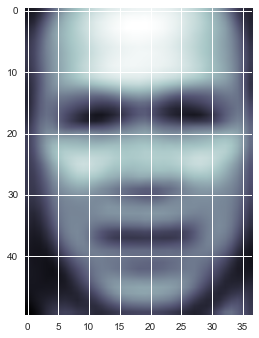

In [13]:
plt.imshow(pca.mean_.reshape((50, 37)), cmap=plt.cm.bone)

In [14]:
print pca.components_.shape

(150, 1850)


In [15]:
trX = pca.transform(trX)
teX = pca.transform(teX)

In [16]:
print trX.shape, trY.shape
print teX.shape, teY.shape

(969, 150) (969, 7)
(324, 150) (324, 7)


## Thenao Moden NNet

In [17]:
X = T.fmatrix()
Y = T.fmatrix()
#Y = T.ivector()

In [18]:
w_h = init_weights((150, 75))
w_h2 = init_weights((75, 75))
w_o = init_weights((75, 7))

In [19]:
noise_h, noise_h2, noise_py_x = model(X, w_h, w_h2, w_o, 0.2, 0.5)
h, h2, py_x = model(X, w_h, w_h2, w_o, 0., 0.)
y_x = T.argmax(py_x, axis=1)

In [20]:
cost = T.mean(T.nnet.categorical_crossentropy(noise_py_x, Y))
params = [w_h, w_h2, w_o]
updates = RMSprop(cost, params, lr=0.001)

In [21]:
train = theano.function(inputs=[X, Y], outputs=cost, updates=updates, allow_input_downcast=True)
predict = theano.function(inputs=[X], outputs=y_x, allow_input_downcast=True)

In [22]:
for i in range(250):
#for i in range(10):    
    for start, end in zip(range(0, len(trX), 128), range(128, len(trX), 128)):
        cost = train(trX[start:end], trY[start:end])
## Begin Debug        
#        print cost
#        print start, end
#        print trY
#        print teY.shape
#        print trX.shape
#       print np.argmax(teY, axis=1)
#        print np.amax(teY)
## End Debug    

    print np.mean(np.argmax(teY, axis=1) == predict(teX))

0.496913580247
0.570987654321
0.638888888889
0.700617283951
0.75
0.753086419753
0.799382716049
0.802469135802
0.802469135802
0.799382716049
0.83024691358
0.814814814815
0.83024691358
0.83024691358
0.83950617284
0.851851851852
0.842592592593
0.845679012346
0.842592592593
0.851851851852
0.842592592593
0.864197530864
0.845679012346
0.848765432099
0.861111111111
0.845679012346
0.854938271605
0.858024691358
0.845679012346
0.845679012346
0.845679012346
0.848765432099
0.83024691358
0.848765432099
0.845679012346
0.845679012346
0.845679012346
0.851851851852
0.858024691358
0.858024691358
0.858024691358
0.861111111111
0.864197530864
0.861111111111
0.864197530864
0.864197530864
0.858024691358
0.848765432099
0.858024691358
0.854938271605
0.867283950617
0.867283950617
0.851851851852
0.873456790123
0.87962962963
0.87037037037
0.858024691358
0.867283950617
0.876543209877
0.858024691358
0.854938271605
0.861111111111
0.867283950617
0.867283950617
0.87037037037
0.873456790123
0.864197530864
0.85802469135

## Try to get the Confusion Matrix

In [168]:
y_pred = predict(teX)
y_pred = pd.core.reshape.get_dummies(y_pred)
y_pred = y_pred.as_matrix()
print(metrics.confusion_matrix(teY, y_pred))

ValueError: multilabel-indicator is not supported

## Debug

In [169]:
print X

<TensorType(float32, matrix)>


In [170]:
theano.printing.debugprint(X)

<TensorType(float32, matrix)> [@A]


In [171]:
print Y

<TensorType(float32, matrix)>


In [172]:
lfw_people.data.shape, lfw_people.target.shape

((1293, 1850), (1293,))

In [173]:
print trX.shape, trY.shape, teX.shape, teY.shape

(969, 200) (969, 7) (324, 200) (324, 7)


In [174]:
pd.DataFrame(trX).head(3)

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
0,144.960558,-373.946129,301.443576,226.757059,325.169034,79.049597,170.735562,-124.676689,-433.331052,184.097258,...,18.817346,4.433210,-27.319618,12.448226,7.919944,-11.971517,11.724554,-40.333784,-34.917987,1.309194
1,-747.202899,-234.613667,-51.397234,781.334350,202.252594,-54.643920,-115.726769,56.081051,44.594086,-145.381856,...,17.395235,42.070773,-0.950765,24.042637,6.083136,11.745354,13.897716,-49.429686,21.331243,-62.351886
2,-895.177139,-718.608619,-988.256426,478.132281,-202.337362,257.863424,-20.624412,-296.334566,379.959103,115.564823,...,19.481635,-11.934357,87.924682,37.849622,4.111629,45.824417,-40.160788,-8.946748,-28.594870,23.518849


In [175]:
pd.DataFrame(teX).head(3)

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
0,-109.343883,499.853306,859.759409,-226.786276,143.873273,-210.368854,-87.593320,270.469639,-313.662358,-209.479842,...,-29.092487,52.767716,24.645740,-16.114965,-20.882521,-76.315040,12.920140,-9.365666,-20.153413,41.249854
1,688.196950,632.933058,-460.493425,-226.411358,197.614076,265.594191,-88.785714,-117.163275,-231.429060,-282.444757,...,-3.784814,-0.532819,-10.443354,2.829836,-33.496714,-9.978662,-13.065058,-22.147353,22.105206,29.863051
2,751.797209,504.306533,1112.223347,-645.618291,-232.348157,294.743418,454.116022,-30.189229,748.704719,265.382356,...,-4.590717,-4.156887,-62.653759,-3.441375,2.729811,28.567276,9.179437,-25.065164,73.532593,32.259999


In [176]:
#trY = pd.core.reshape.get_dummies(trY)
#trY.head(3)

In [177]:

#teY = pd.core.reshape.get_dummies(teY)
#teY.head(3)

In [178]:
zip((0, len(trX), 128), range(128, len(trX), 128))

[(0, 128), (969, 256), (128, 384)]

In [182]:
print teX.shape, teY.shape

 (324, 200) (324, 7)


In [183]:
print trX.shape, trY.shape

(969, 200) (969, 7)


In [188]:
#y_pred = predict(teX)
#y_pred = pd.core.reshape.get_dummies(y_pred)
#y_pred = y_pred.as_matrix()
y_pred

array([[ 0.,  0.,  0., ...,  0.,  0.,  1.],
       [ 1.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  1.],
       ..., 
       [ 0.,  0.,  0., ...,  1.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  1.,  0.]])

Theano's "predict" output

In [189]:
predict(trX)

array([3, 4, 3, 2, 3, 3, 2, 1, 1, 3, 1, 3, 3, 4, 0, 1, 1, 4, 4, 1, 4, 1, 2,
       3, 0, 3, 6, 2, 3, 4, 1, 2, 6, 1, 6, 3, 3, 3, 3, 5, 2, 3, 3, 5, 1, 3,
       1, 3, 3, 1, 3, 1, 5, 3, 3, 3, 3, 1, 1, 3, 3, 0, 1, 3, 3, 4, 3, 3, 1,
       3, 3, 4, 3, 2, 3, 4, 4, 1, 5, 4, 2, 1, 2, 3, 1, 6, 2, 0, 2, 3, 6, 3,
       3, 6, 4, 1, 3, 5, 1, 3, 3, 0, 1, 6, 3, 3, 1, 3, 1, 2, 1, 3, 6, 1, 6,
       6, 4, 2, 6, 1, 1, 3, 3, 3, 3, 3, 3, 5, 4, 6, 1, 3, 4, 3, 3, 4, 3, 3,
       6, 3, 5, 6, 0, 3, 3, 4, 3, 0, 2, 6, 3, 3, 1, 3, 1, 5, 6, 3, 0, 1, 3,
       3, 0, 1, 1, 3, 6, 6, 6, 3, 5, 5, 4, 0, 4, 3, 6, 3, 3, 3, 5, 3, 6, 3,
       3, 2, 3, 3, 1, 3, 3, 3, 0, 6, 3, 3, 3, 0, 6, 6, 4, 0, 3, 3, 4, 3, 3,
       3, 3, 3, 3, 3, 1, 2, 6, 1, 3, 2, 1, 1, 3, 1, 0, 3, 3, 1, 4, 3, 3, 3,
       4, 1, 5, 4, 6, 3, 1, 2, 3, 1, 3, 1, 6, 6, 3, 3, 1, 4, 2, 1, 6, 2, 0,
       1, 4, 1, 1, 3, 6, 3, 4, 1, 3, 3, 3, 3, 3, 3, 3, 6, 1, 1, 3, 5, 1, 3,
       2, 3, 4, 3, 4, 5, 6, 3, 3, 3, 5, 3, 3, 3, 3, 1, 1, 4, 1, 3, 6, 2, 3,
       3, 6,

In [190]:
teY

array([[ 0.,  0.,  0., ...,  0.,  0.,  1.],
       [ 1.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  1.],
       ..., 
       [ 0.,  0.,  0., ...,  1.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  1.,  0.]])

In [191]:
y_pred

array([[ 0.,  0.,  0., ...,  0.,  0.,  1.],
       [ 1.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  1.],
       ..., 
       [ 0.,  0.,  0., ...,  1.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  1.,  0.]])

In [192]:
print(metrics.f1_score(teY, y_pred))

0.874640747741
